In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import matplotlib.lines as mlines

In [55]:
def meanCI(a, conf=0.95):
    mean, sem, m = np.mean(a), st.sem(a), st.t.ppf((1+conf)/2., len(a)-1)
    return mean, sem*1.986

In [56]:
def get_bucket(x):
    if x == 1:
        return '1'
    elif x < 5:
        return '2-4'
    elif x < 10:
        return '5-9'
    else:
        return '10+'

In [57]:
df = pd.read_csv('data.csv')
df.head()

,id,pub_year,years_since_pub,authorships,countries_distinct_count,institutions_distinct_count,concepts,year_1,year_5,year_10,year_25,year_50,total_citations
0,https://openalex.org/W153152856,2007,16,10,0,0,Medicine,0,0,0,0,0,0
1,https://openalex.org/W2418723612,2002,21,2,1,1,Medicine,0,0,0,0,0,0
2,https://openalex.org/W2092897175,2010,13,9,1,1,Medicine,0,9,18,22,22,22
3,https://openalex.org/W2620772774,2013,10,4,2,2,Medicine,0,0,0,0,0,0
4,https://openalex.org/W2064953989,1926,97,1,0,0,Art,0,0,0,0,0,2


In [58]:
modern_era = df[(df['pub_year'] > 1944) & (df['pub_year'] < 2024) & (df['authorships'] >= 1)]


# top_5 = list(modern_era['concepts'].value_counts().head(5).reset_index()['index'].values)
top_5 = ['Medicine', 'Computer science', 'Biology', 'Chemistry', 'Physics']
modern_era['concepts_adjusted'] = modern_era['concepts'].apply(lambda x: x if x in top_5 else 'Other')
modern_era['author_bucket'] = modern_era['authorships'].apply(lambda x: get_bucket(x))
modern_era = modern_era.loc[modern_era['countries_distinct_count'] > 0]
modern_era = modern_era.loc[modern_era['institutions_distinct_count'] > 0]
modern_era.head()

/var/folders/q2/jh49nbrj73x3lvwvlz9642xm0000gp/T/ipykernel_56672/877167366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modern_era['concepts_adjusted'] = modern_era['concepts'].apply(lambda x: x if x in top_5 else 'Other')
/var/folders/q2/jh49nbrj73x3lvwvlz9642xm0000gp/T/ipykernel_56672/877167366.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modern_era['author_bucket'] = modern_era['authorships'].apply(lambda x: get_bucket(x))


,id,pub_year,years_since_pub,authorships,countries_distinct_count,institutions_distinct_count,concepts,year_1,year_5,year_10,year_25,year_50,total_citations,concepts_adjusted,author_bucket
1,https://openalex.org/W2418723612,2002,21,2,1,1,Medicine,0,0,0,0,0,0,Medicine,2-4
2,https://openalex.org/W2092897175,2010,13,9,1,1,Medicine,0,9,18,22,22,22,Medicine,5-9
3,https://openalex.org/W2620772774,2013,10,4,2,2,Medicine,0,0,0,0,0,0,Medicine,2-4
5,https://openalex.org/W4230330799,2020,3,6,2,2,Medicine,0,0,0,0,0,0,Medicine,5-9
7,https://openalex.org/W4247533799,2009,14,4,1,1,Medicine,0,1,1,1,1,2,Medicine,2-4


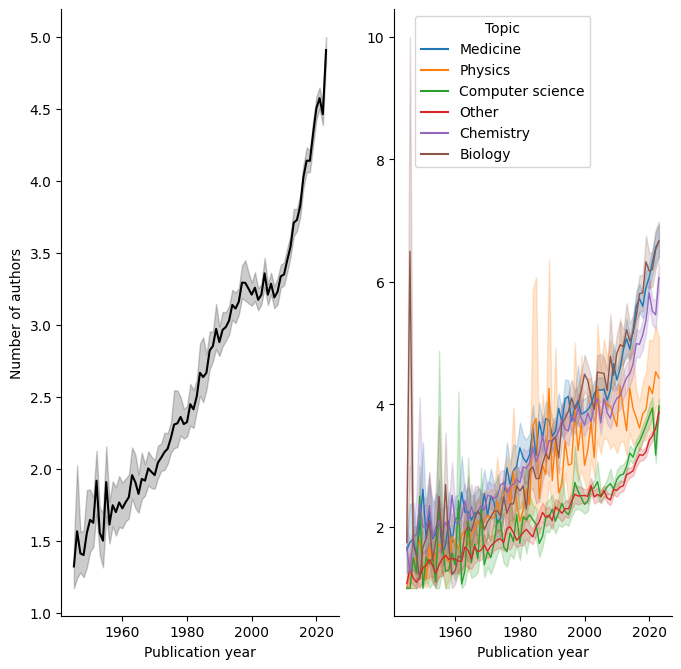

In [59]:
cm = 1/2.54
axd = plt.figure(figsize=(20*cm, 20*cm)).subplot_mosaic(
    """
    AB
    """
)

sns.lineplot(data = modern_era, x = 'pub_year', y = 'authorships', ax = axd['A'], color = 'black')
axd['A'].set_ylabel('Number of authors')
axd['A'].set_xlabel('Publication year')
sns.lineplot(data = modern_era, x = 'pub_year', y = 'authorships', hue = 'concepts_adjusted', ax = axd['B'], linewidth = 1, alpha = 1)
axd['B'].set_ylabel('')
axd['B'].set_xlabel('Publication year')
axd['B'].legend(loc='upper left', bbox_to_anchor=(0.05, 1), title = 'Topic')

sns.despine()

plt.savefig('./figures/num_authors_temporal.pdf', bbox_inches='tight', dpi = 300)


In [60]:
def get_offset(j):
    if j == 0:
        return -0.2
    elif j == 1:
        return -0.1
    elif j == 2:
        return 0.1
    else:
        return 0.2
    
color_palette = {
    'Medicine' : 'tab:blue',
    'Other' : 'tab:orange',
    'Computer science' : 'tab:red',
    'Biology' : 'tab:purple',
    'Chemistry' : 'tab:brown',
    'Physics' : 'tab:green'
}

def plot_year_group_citations_splitby_concepts(df, ax):
    
    styles = ['o', 's', 'D', 'X']
    ax.set_xlim(-0.5, 5.5)
    
    for i, concept in enumerate(list(['Medicine', 'Computer science', 'Biology', 'Chemistry', 'Physics', 'Other'])):
        for j, author_bucket in enumerate(['1', '2-4', '5-9', '10+']):
            vals = list(df[(df['concepts_adjusted'] == concept) & (df['author_bucket'] == author_bucket)]['total_citations'].values)
            mean, ci = meanCI(vals)
            ax.errorbar(i + get_offset(j), mean, yerr=ci, color = color_palette[concept], fmt = styles[j], elinewidth=1, ms=5, alpha = 1)
            
    ax.set_xticklabels(['Medicine', 'Medicine', 'Computer science', 'Biology', 'Chemistry', 'Physics', 'Other'], fontsize = 8)
    ax.set_xlabel('Topic', fontsize = 10)
    ax.set_ylabel('Number of citations', fontsize = 10)
    
    handle_1 = mlines.Line2D([], [], color='grey', marker='o', linestyle='None',
                          markersize=5, label='1')
    handle_2 = mlines.Line2D([], [], color='grey', marker='s', linestyle='None',
                          markersize=5, label='2-4')
    handle_3 = mlines.Line2D([], [], color='grey', marker='D', linestyle='None',
                          markersize=5, label='5-9')
    handle_4 = mlines.Line2D([], [], color='grey', marker='X', linestyle='None',
                          markersize=5, label='10+')

    plt.legend(handles=[handle_1, handle_2, handle_3, handle_4], title = 'Number of authors', loc='upper left', bbox_to_anchor=(0.75, 1))
    sns.despine()
            

            

        
        

/var/folders/q2/jh49nbrj73x3lvwvlz9642xm0000gp/T/ipykernel_56672/973625875.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Medicine', 'Medicine', 'Computer science', 'Biology', 'Chemistry', 'Physics', 'Other'], fontsize = 8)


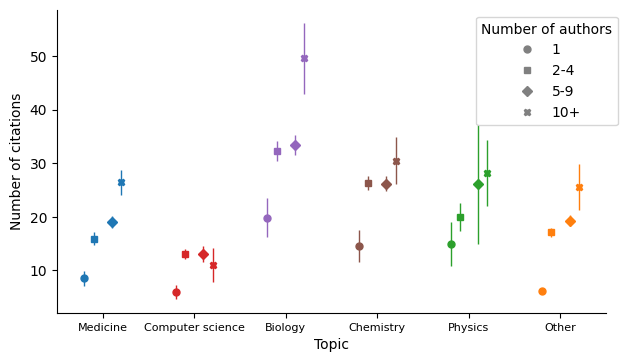

In [61]:
axd = plt.figure(figsize=(18*cm, 10*cm)).subplot_mosaic(
    """
    A
    """
)
plot_year_group_citations_splitby_concepts(modern_era, axd['A'])

plt.savefig('./figures/citations_by_topic_and_num_authors.pdf', bbox_inches='tight', dpi = 300)

In [62]:
def plot_boxes_per_topic_authorbucket(df, axd):
    
    topics = ['Medicine', 'Computer science', 'Biology', 'Chemistry', 'Physics', 'Other']
    styles = ['o', 's', 'D', 'X']
    
    for topic, letter in zip(topics, ['A', 'B', 'C', 'D', 'E', 'F']):
        ax = axd[letter]
        times = ['year_1', 'year_5', 'year_10', 'total_citations']
        ax.set_xlim(-0.5, 3.5)        
        for i, time in enumerate(times):
            for j, author_bucket in enumerate(['1', '2-4', '5-9', '10+']):
                vals = list(df[(df['concepts_adjusted'] == topic) & (df['author_bucket'] == author_bucket)][time].values)
                mean, ci = meanCI(vals)
                ax.errorbar(i + get_offset(j), mean, yerr=ci, color = color_palette[topic], fmt = styles[j], elinewidth=1, ms=5, alpha = 1)
                
        ax.set_title(topic, fontsize = 10)
                
    
        ax.set_xticklabels(['1 year', '1 year', '5 years', '10 years', 'Total'], fontsize = 8)    
        
        if letter in ['A', 'C', 'E']:
            ax.set_ylabel('Number of citations', fontsize = 10)
        else:
            ax.set_ylabel('')
            
        handle_1 = mlines.Line2D([], [], color='grey', marker='o', linestyle='None',
                          markersize=5, label='1')
        handle_2 = mlines.Line2D([], [], color='grey', marker='s', linestyle='None',
                            markersize=5, label='2-4')
        handle_3 = mlines.Line2D([], [], color='grey', marker='D', linestyle='None',
                            markersize=5, label='5-9')
        handle_4 = mlines.Line2D([], [], color='grey', marker='X', linestyle='None',
                            markersize=5, label='10+')

        plt.legend(handles=[handle_1, handle_2, handle_3, handle_4], title = 'Number of authors', loc='upper left', bbox_to_anchor=(1.05, 2))

/var/folders/q2/jh49nbrj73x3lvwvlz9642xm0000gp/T/ipykernel_56672/296488821.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1 year', '1 year', '5 years', '10 years', 'Total'], fontsize = 8)


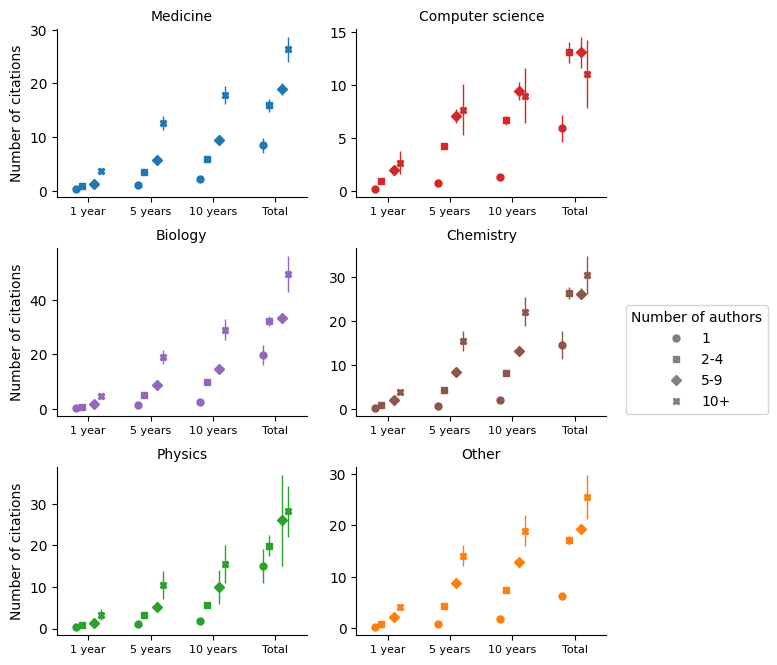

In [63]:
axd = plt.figure(figsize=(18*cm, 20*cm)).subplot_mosaic(
    """
    AB
    CD
    EF
    """
)

plot_boxes_per_topic_authorbucket(modern_era, axd)
plt.subplots_adjust(hspace=0.3)
sns.despine()

plt.savefig('./figures/num_citations_by_topic_and_num_authors.pdf', bbox_inches='tight', dpi = 300)

In [64]:
# modern_era.head()

modern_era['multiCountry'] = modern_era.apply(lambda row: True if row['countries_distinct_count'] > 1 else False, axis = 1)
modern_era['multiInst'] = modern_era.apply(lambda row: True if row['institutions_distinct_count'] > 1 else False, axis = 1)

modern_era.head()

,id,pub_year,years_since_pub,authorships,countries_distinct_count,institutions_distinct_count,concepts,year_1,year_5,year_10,year_25,year_50,total_citations,concepts_adjusted,author_bucket,multiCountry,multiInst
1,https://openalex.org/W2418723612,2002,21,2,1,1,Medicine,0,0,0,0,0,0,Medicine,2-4,False,False
2,https://openalex.org/W2092897175,2010,13,9,1,1,Medicine,0,9,18,22,22,22,Medicine,5-9,False,False
3,https://openalex.org/W2620772774,2013,10,4,2,2,Medicine,0,0,0,0,0,0,Medicine,2-4,True,True
5,https://openalex.org/W4230330799,2020,3,6,2,2,Medicine,0,0,0,0,0,0,Medicine,5-9,True,True
7,https://openalex.org/W4247533799,2009,14,4,1,1,Medicine,0,1,1,1,1,2,Medicine,2-4,False,False


In [65]:
def plot_boxes_per_topic_international(df, axd):
    
    topics = ['Medicine', 'Computer science', 'Biology', 'Chemistry', 'Physics', 'Other']
    styles = ['o', 's', 'D', 'X']
    
    for topic, letter in zip(topics, ['A', 'B', 'C', 'D', 'E', 'F']):
        ax = axd[letter]
        times = ['year_1', 'year_5', 'year_10', 'total_citations']
        ax.set_xlim(-0.5, 3.5)        
        for i, time in enumerate(times):
            
            j = 0
            vals = list(df[(df['concepts_adjusted'] == topic) & (df['multiCountry'] == True)][time].values)
            mean, ci = meanCI(vals)
            ax.errorbar(i + get_offset(j), mean, yerr=ci, color = color_palette[topic], fmt = styles[j], elinewidth=1, ms=5, alpha = 1)
            
            j = 1
            vals = list(df[(df['concepts_adjusted'] == topic) & (df['multiCountry'] == False)][time].values)
            mean, ci = meanCI(vals)
            ax.errorbar(i + get_offset(j), mean, yerr=ci, color = color_palette[topic], fmt = styles[j], elinewidth=1, ms=5, alpha = 1)
            
            j = 2
            vals = list(df[(df['concepts_adjusted'] == topic) & (df['multiInst'] == True)][time].values)
            mean, ci = meanCI(vals)
            ax.errorbar(i + get_offset(j), mean, yerr=ci, color = color_palette[topic], fmt = styles[j], elinewidth=1, ms=5, alpha = 1)
            
            j = 3
            vals = list(df[(df['concepts_adjusted'] == topic) & (df['multiInst'] == False)][time].values)
            mean, ci = meanCI(vals)
            ax.errorbar(i + get_offset(j), mean, yerr=ci, color = color_palette[topic], fmt = styles[j], elinewidth=1, ms=5, alpha = 1)
                
        ax.set_title(topic, fontsize = 10)
                
    
        ax.set_xticklabels(['1 year', '1 year', '5 years', '10 years', 'Total'], fontsize = 8)    
        
        if letter in ['A', 'C', 'E']:
            ax.set_ylabel('Number of citations', fontsize = 10)
        else:
            ax.set_ylabel('')
            
        handle_1 = mlines.Line2D([], [], color='grey', marker='o', linestyle='None',
                          markersize=5, label='Multi-Country')
        handle_2 = mlines.Line2D([], [], color='grey', marker='s', linestyle='None',
                            markersize=5, label='Single Country')
        handle_3 = mlines.Line2D([], [], color='grey', marker='D', linestyle='None',
                            markersize=5, label='Multi-Institution')
        handle_4 = mlines.Line2D([], [], color='grey', marker='X', linestyle='None',
                            markersize=5, label='Single Institution')

        plt.legend(handles=[handle_1, handle_2, handle_3, handle_4], title = 'Collab Type', loc='upper left', bbox_to_anchor=(1.05, 2))

/var/folders/q2/jh49nbrj73x3lvwvlz9642xm0000gp/T/ipykernel_56672/2118802656.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1 year', '1 year', '5 years', '10 years', 'Total'], fontsize = 8)


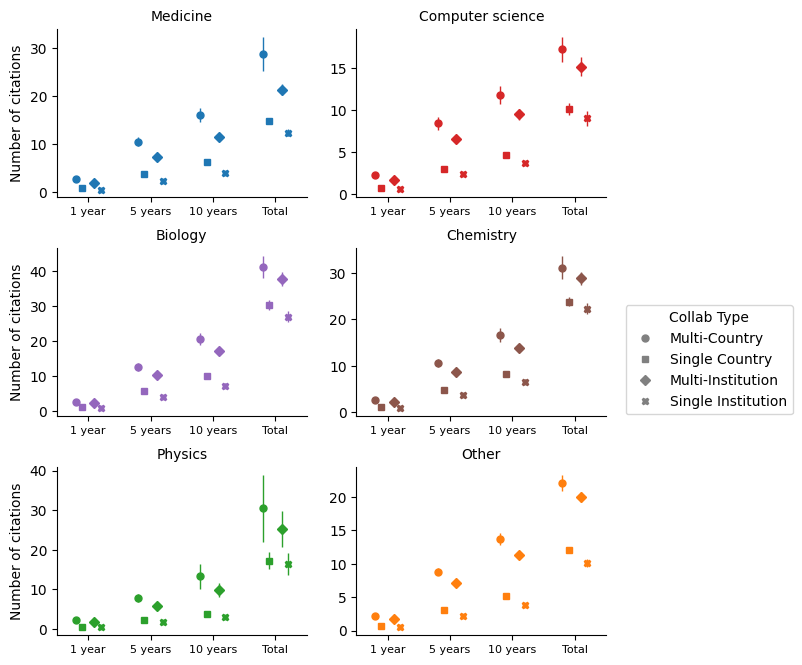

In [66]:
axd = plt.figure(figsize=(18*cm, 20*cm)).subplot_mosaic(
    """
    AB
    CD
    EF
    """
)

plot_boxes_per_topic_international(modern_era, axd)
plt.subplots_adjust(hspace=0.3)
sns.despine()

plt.savefig('./figures/num_citations_by_topic_and_collabType.pdf', bbox_inches='tight', dpi = 300)

In [67]:
modern_era.head()

,id,pub_year,years_since_pub,authorships,countries_distinct_count,institutions_distinct_count,concepts,year_1,year_5,year_10,year_25,year_50,total_citations,concepts_adjusted,author_bucket,multiCountry,multiInst
1,https://openalex.org/W2418723612,2002,21,2,1,1,Medicine,0,0,0,0,0,0,Medicine,2-4,False,False
2,https://openalex.org/W2092897175,2010,13,9,1,1,Medicine,0,9,18,22,22,22,Medicine,5-9,False,False
3,https://openalex.org/W2620772774,2013,10,4,2,2,Medicine,0,0,0,0,0,0,Medicine,2-4,True,True
5,https://openalex.org/W4230330799,2020,3,6,2,2,Medicine,0,0,0,0,0,0,Medicine,5-9,True,True
7,https://openalex.org/W4247533799,2009,14,4,1,1,Medicine,0,1,1,1,1,2,Medicine,2-4,False,False


<AxesSubplot:xlabel='countries_distinct_count', ylabel='total_citations'>

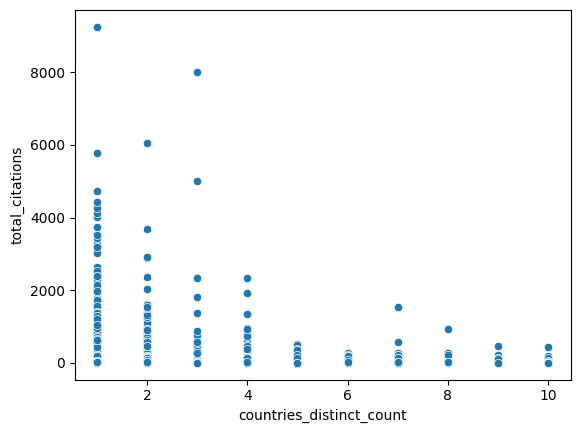

In [68]:
sns.scatterplot(data = modern_era.loc[(modern_era['countries_distinct_count'] <= 10) & (modern_era['countries_distinct_count'] > 0)], x = 'countries_distinct_count', y = 'total_citations')

In [69]:
def standardize(x):
    return (x - np.mean(x)) / np.std(x)


from scipy.stats import pearsonr
from scipy.stats import spearmanr

temp = modern_era.loc[(modern_era['countries_distinct_count'] < 3) & (modern_era['total_citations'] > 0)]

x = standardize(temp['countries_distinct_count'].values)
print(x)
y = standardize(temp['total_citations'].values)

print(y)

print(spearmanr(x, y))


temp = modern_era.loc[(modern_era['institutions_distinct_count'] < 3) & (modern_era['total_citations'] > 0)]
x = standardize(temp['institutions_distinct_count'].values)
print(x)
y = standardize(temp['total_citations'].values)

print(y)

print(spearmanr(x, y))



[-0.43184657 -0.43184657 -0.43184657 ... -0.43184657 -0.43184657
 -0.43184657]
[-0.06258386 -0.28714951 -0.29837779 ... -0.28714951 -0.17486669
 -0.08504043]
SpearmanrResult(correlation=0.0813849249924962, pvalue=3.8962087898420486e-177)
[-0.70550774 -0.70550774  1.41741889 ...  1.41741889  1.41741889
  1.41741889]
[-0.04793107 -0.2697127  -0.28080178 ...  0.09622699 -0.2697127
 -0.15882188]
SpearmanrResult(correlation=0.08168722703528823, pvalue=6.196275457838425e-144)


In [70]:
single_country = modern_era.loc[modern_era['countries_distinct_count'] == 1]
multi_country = modern_era.loc[modern_era['countries_distinct_count'] > 1]

print(single_country['total_citations'].mean())
print(single_country['total_citations'].std())
print(multi_country['total_citations'].mean())
print(multi_country['total_citations'].std())

15.431900425498071
68.10363034231646
26.518781663165697
101.04645410903488


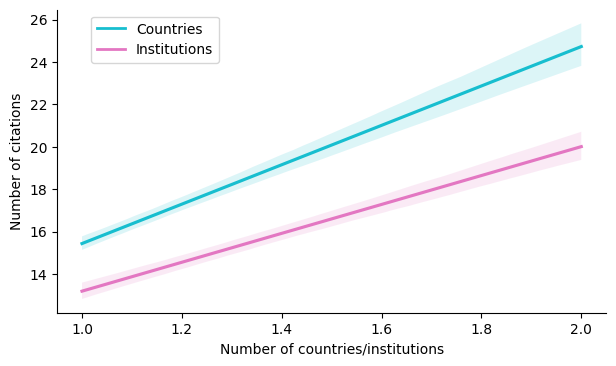

In [71]:
axd = plt.figure(figsize=(18*cm, 10*cm)).subplot_mosaic(
    """
    A
    """
)

sns.regplot(data = modern_era.loc[modern_era['countries_distinct_count'] <= 2], x = 'countries_distinct_count', y = 'total_citations', scatter = False, color = 'tab:cyan', ax = axd['A'])
sns.regplot(data = modern_era.loc[modern_era['institutions_distinct_count'] <= 2], x = 'institutions_distinct_count', y = 'total_citations', scatter = False, color = 'tab:pink', ax = axd['A'])

from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='tab:cyan', lw=2),
                Line2D([0], [0], color='tab:pink', lw=2)]


axd['A'].set_ylabel('Number of citations', fontsize = 10)
axd['A'].set_xlabel('Number of countries/institutions', fontsize = 10)

axd['A'].legend(custom_lines, ['Countries', 'Institutions'], loc='upper left', bbox_to_anchor=(0.05, 1))

sns.despine()

plt.savefig('./figures/countries_institutions_vs_citations.pdf', bbox_inches='tight', dpi = 300)